In [90]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 
import payoff as pf

%reload_ext autoreload
%autoreload 2


In [91]:

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

data


[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120483,237.429871
2023-04-28,546.263367,242.368103
2023-05-02,545.868896,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [92]:
def multi_asset_gbm(data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulation for 1 day and 1 simulation 

    Params:
        fdos : Specified first day of simulation, to be used in pricing 
        data : get data function 
    
    """
    try:
        log_returns_list = []
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker]/data[ticker].shift(1))
            log_returns.dropna(inplace = True) # A series
            log_returns_list.append(log_returns)
        
    except Exception as e:
        raise Exception("Error at generating log return.")


    try: 
        cov_matrix = np.cov(np.array(log_returns_list))
        L = np.linalg.cholesky(cov_matrix)
        
    except Exception as e:
        raise Exception("Error at covariance matrix.")

    try:
        
        date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
        s0_vector_fdos = data.loc[fdos]
        sim_window = dates.num_business_days(fdos, cs.final_fixing_date)
        print(sim_window)
        sim_data = pd.DataFrame(np.zeros((sim_window, cs.num_ticker)), columns = cs.ticker_list)
        Zlist = np.random.normal(0, 1, (cs.num_ticker, sim_window))
        for t in range(sim_window):
            Z = Zlist[:, t]
            LZ = np.dot(L, Z.T)
            print(f"Time step {t}, Z: {Z}, LZ: {LZ}")
            for i in range(cs.num_ticker):
                s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
                print(f"Ticker {cs.ticker_list[i]}, s0_vector_fdos: {s0_vector_fdos[i]}")
                sim_data.loc[t, cs.ticker_list[i]] = s0_vector_fdos[i]

    

    except Exception as e:
        raise Exception("Error at Simulation")
    
    sim_data.index = date_list
    return sim_data




In [93]:

simdata = multi_asset_gbm(data= data, fdos = cs.initial_fixing_date)
simdata

315
Time step 0, Z: [0.70257996 1.18485554], LZ: [0.01627809 0.01985327]
Ticker LONN.SW, s0_vector_fdos: 551.056159763155
Ticker SIKA.SW, s0_vector_fdos: 242.20793209626072
Time step 1, Z: [ 0.10413359 -0.04517251], LZ: [2.41267377e-03 2.90087822e-05]
Ticker LONN.SW, s0_vector_fdos: 552.4261529061038
Ticker SIKA.SW, s0_vector_fdos: 242.232159026209
Time step 2, Z: [ 1.94965384 -0.77781713], LZ: [0.04517158 0.00143955]
Ticker LONN.SW, s0_vector_fdos: 577.9929710618788
Ticker SIKA.SW, s0_vector_fdos: 242.5983428468973
Time step 3, Z: [ 0.04138715 -0.20599469], LZ: [ 0.0009589  -0.00246991]
Ticker LONN.SW, s0_vector_fdos: 578.5881843415782
Ticker SIKA.SW, s0_vector_fdos: 242.01707122673866
Time step 4, Z: [0.56546464 0.72874964], LZ: [0.01310126 0.01301127]
Ticker LONN.SW, s0_vector_fdos: 586.2595440643971
Ticker SIKA.SW, s0_vector_fdos: 245.20400778693184
Time step 5, Z: [-0.4411551   0.57293352], LZ: [-0.01022113  0.00491231]
Ticker LONN.SW, s0_vector_fdos: 580.3386597464388
Ticker SIKA

C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, inte

,LONN.SW,SIKA.SW
2023-04-27,551.056160,242.207932
2023-04-28,552.426153,242.232159
2023-05-02,577.992971,242.598343
2023-05-03,578.588184,242.017071
2023-05-04,586.259544,245.204008
...,...,...
2024-07-24,435.441463,319.575627
2024-07-25,438.124123,317.729221
2024-07-26,446.601599,317.985405
2024-07-29,454.548163,313.500091


In [98]:
def multi_asset_gbm_n_sims(plot : bool, plotasset : bool, nsims, data, fdos) -> pd.DataFrame:
    """
    n simulations for 1 day 

    params:
        fdos: specified day for simulation, to be used in pricing 
        nsims: number of simulations to be carried out on this specified day
    
    """
    
    sim_data_combine = pd.DataFrame()
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    try: 
        for n in range(nsims):
            
            sim_data = multi_asset_gbm(data, fdos)
            sim_data_combine = pd.concat([sim_data_combine,sim_data], axis =1 )
        # formatting Dates 
        date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
        if (len(sim_data) == len(date_list)):
            sim_data_combine.index = date_list
        else:
            print((f"The length of sim_data and dates is different: {len(sim_data)} and {len(date_list)}\n"))
    except Exception as e:
        raise Exception("Error at Simulation")


        
    if plot == True: 
        fig, ax = plt.subplots()
        
        realised_price.plot(ax=ax)
        sim_data.plot(ax=ax)
        
    if plotasset:
        # Select odd-numbered columns for Lonza paths
        lonza_path = sim_data_combine.iloc[:, ::2]
        # Select the realized price for Lonza (assuming it's the first column)
        realised_price_lonza = realised_price.iloc[:, 0]  # Adjust the index if necessary

        # Select even-numbered columns for Sika paths
        sika_path = sim_data_combine.iloc[:, 1::2]
        # Select the realized price for Sika (assuming it's the second column)
        realised_price_sika = realised_price.iloc[:, 1]  # Adjust the index if necessary

        # Plot Lonza paths and realized price
        fig, ax = plt.subplots()
        lonza_path.plot(ax=ax, alpha=0.4, legend=False)
        realised_price_lonza.plot(ax=ax, color='black', linewidth=2, label='Realised Price Lonza')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[handles[-1]], labels=[labels[-1]])  # Only keep the last legend entry
        plt.title('Lonza Path under Multi Asset GBM')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.show()

        # Plot Sika paths and realized price
        fig, ax = plt.subplots()
        sika_path.plot(ax=ax, alpha=0.4, legend=False)
        realised_price_sika.plot(ax=ax, color='black', linewidth=2, label='Realised Price Sika')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=[handles[-1]], labels=[labels[-1]])  # Only keep the last legend entry
        plt.title('Sika Path under Multi Asset GBM')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.show()
    return sim_data_combine

315
Time step 0, Z: [1.18783037 0.9348654 ], LZ: [0.02752087 0.01946731]
Ticker LONN.SW, s0_vector_fdos: 557.2865202464334
Ticker SIKA.SW, s0_vector_fdos: 242.11446703329315
Time step 1, Z: [0.35371214 0.80114449], LZ: [0.00819517 0.01269546]
Ticker LONN.SW, s0_vector_fdos: 561.9118773674256
Ticker SIKA.SW, s0_vector_fdos: 245.2252279909048
Time step 2, Z: [-2.69515909  0.33246109], LZ: [-0.06244421 -0.01179188]
Ticker LONN.SW, s0_vector_fdos: 527.9339542402557
Ticker SIKA.SW, s0_vector_fdos: 242.3677546342836
Time step 3, Z: [ 0.01876955 -0.54570078], LZ: [ 0.00043487 -0.00708854]
Ticker LONN.SW, s0_vector_fdos: 528.2007526627319
Ticker SIKA.SW, s0_vector_fdos: 240.67288695032573
Time step 4, Z: [1.3023433  1.87755821], LZ: [0.03017403 0.03259475]
Ticker LONN.SW, s0_vector_fdos: 544.4198942980928
Ticker SIKA.SW, s0_vector_fdos: 248.66446577908195
Time step 5, Z: [-0.53601585 -1.24722292], LZ: [-0.01241897 -0.0196764 ]
Ticker LONN.SW, s0_vector_fdos: 537.7384083477122
Ticker SIKA.SW, s

C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, inte

315
Time step 0, Z: [-0.99533531 -0.77207555], LZ: [-0.02306095 -0.01616354]
Ticker LONN.SW, s0_vector_fdos: 529.7989977337385
Ticker SIKA.SW, s0_vector_fdos: 233.63960344625337
Time step 1, Z: [ 0.15080929 -1.82382116], LZ: [ 0.0034941  -0.02316231]
Ticker LONN.SW, s0_vector_fdos: 531.6908188210821
Ticker SIKA.SW, s0_vector_fdos: 228.3063749941225
Time step 2, Z: [ 0.06102956 -0.09145391], LZ: [ 0.001414   -0.00084049]
Ticker LONN.SW, s0_vector_fdos: 532.4806248202398
Ticker SIKA.SW, s0_vector_fdos: 228.13076632268206
Time step 3, Z: [ 0.34244603 -1.09361206], LZ: [ 0.00793414 -0.01237588]
Ticker LONN.SW, s0_vector_fdos: 536.7599724359699
Ticker SIKA.SW, s0_vector_fdos: 225.34084818334162
Time step 4, Z: [ 0.35684707 -0.03714594], LZ: [0.0082678  0.00165198]
Ticker LONN.SW, s0_vector_fdos: 541.2542753619124
Ticker SIKA.SW, s0_vector_fdos: 225.7294423698413
Time step 5, Z: [-0.98623408  0.97608623], LZ: [-0.02285008  0.0069603 ]
Ticker LONN.SW, s0_vector_fdos: 529.0640272468709
Ticker 

C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, inte

315
Time step 0, Z: [-0.02619731 -1.31391626], LZ: [-0.00060697 -0.01749604]
Ticker LONN.SW, s0_vector_fdos: 541.8296581513588
Ticker SIKA.SW, s0_vector_fdos: 233.32848446081664
Time step 1, Z: [0.63058685 0.28089238], LZ: [0.01461008 0.00749216]
Ticker LONN.SW, s0_vector_fdos: 549.8426325288539
Ticker SIKA.SW, s0_vector_fdos: 235.09987823838364
Time step 2, Z: [-0.06245737  1.10686718], LZ: [-0.00144708  0.01423157]
Ticker LONN.SW, s0_vector_fdos: 549.0861778726794
Ticker SIKA.SW, s0_vector_fdos: 238.4865759301723
Time step 3, Z: [-0.54367126 -1.30784751], LZ: [-0.01259633 -0.02052237]
Ticker LONN.SW, s0_vector_fdos: 542.2512374421864
Ticker SIKA.SW, s0_vector_fdos: 233.6587373406696
Time step 4, Z: [1.54005785 1.14498238], LZ: [0.03568164 0.0243545 ]
Ticker LONN.SW, s0_vector_fdos: 561.9885269245378
Ticker SIKA.SW, s0_vector_fdos: 239.43624340842817
Time step 5, Z: [ 1.37687394 -0.07515058], LZ: [0.03190083 0.00727371]
Ticker LONN.SW, s0_vector_fdos: 580.2462753519462
Ticker SIKA.SW,

C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, inte

315
Time step 0, Z: [-0.72658474 -1.63478098], LZ: [-0.01683426 -0.02593471]
Ticker LONN.SW, s0_vector_fdos: 533.1081831234676
Ticker SIKA.SW, s0_vector_fdos: 231.3677888605847
Time step 1, Z: [-2.49291359 -1.9996141 ], LZ: [-0.05775838 -0.04135246]
Ticker LONN.SW, s0_vector_fdos: 503.22448284381403
Ticker SIKA.SW, s0_vector_fdos: 222.01104916427232
Time step 2, Z: [-0.19878488  0.8171305 ], LZ: [-0.00460565  0.00958976]
Ticker LONN.SW, s0_vector_fdos: 500.94738217105066
Ticker SIKA.SW, s0_vector_fdos: 224.16623980168518
Time step 3, Z: [ 0.31471236 -0.02684418], LZ: [0.00729158 0.00153498]
Ticker LONN.SW, s0_vector_fdos: 504.6489364649956
Ticker SIKA.SW, s0_vector_fdos: 224.5265392355983
Time step 4, Z: [-0.34199877 -1.01307525], LZ: [-0.00792378 -0.01542183]
Ticker LONN.SW, s0_vector_fdos: 500.701240760531
Ticker SIKA.SW, s0_vector_fdos: 221.10619196108988
Time step 5, Z: [0.34146508 0.05568653], LZ: [0.00791141 0.00278468]
Ticker LONN.SW, s0_vector_fdos: 504.71371834495767
Ticker SI

C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0_vector_fdos[i] = s0_vector_fdos[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20416\1933382233.py:41: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, inte

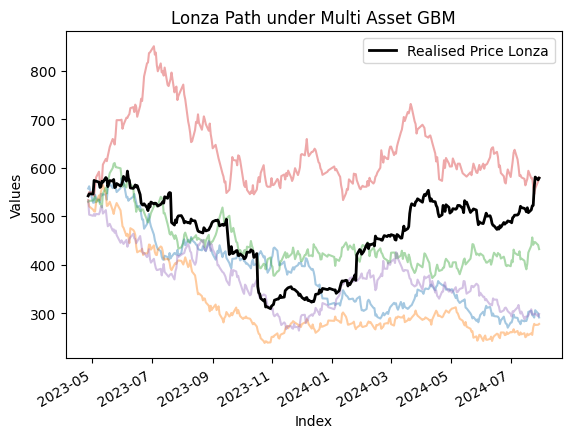

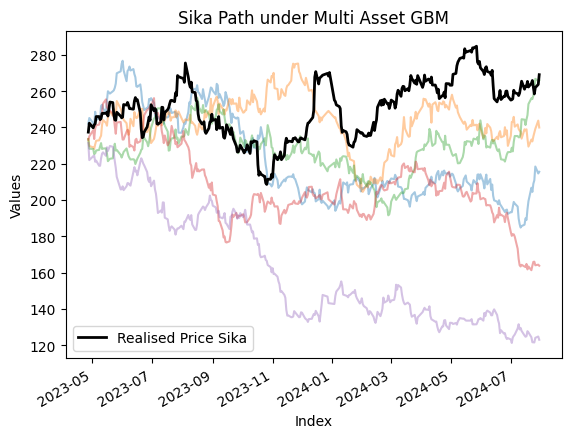

,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW,LONN.SW,SIKA.SW
2023-04-27,557.286520,242.114467,533.144240,233.640984,529.798998,233.639603,541.829658,233.328484,533.108183,231.367789
2023-04-28,561.911877,245.225228,520.337388,229.822979,531.690819,228.306375,549.842633,235.099878,503.224483,222.011049
2023-05-02,527.933954,242.367755,513.771246,229.024711,532.480625,228.130766,549.086178,238.486576,500.947382,224.166240
2023-05-03,528.200753,240.672887,509.924180,228.269704,536.759972,225.340848,542.251237,233.658737,504.648936,224.526539
2023-05-04,544.419894,248.664466,509.591403,230.694282,541.254275,225.729442,561.988527,239.436243,500.701241,221.106192
...,...,...,...,...,...,...,...,...,...,...
2024-07-24,294.131946,208.999597,270.429920,235.031957,440.994541,257.576447,560.786793,165.886343,296.796780,121.561499
2024-07-25,290.642238,210.876784,277.770698,237.086053,446.592482,260.408197,545.420880,165.995566,297.904895,121.463890
2024-07-26,305.898377,218.472981,275.426822,239.233766,446.545972,266.828881,557.084742,164.027355,298.894265,124.008945
2024-07-29,299.232888,214.638450,275.842369,243.776221,440.537861,265.668673,572.156303,164.344732,293.363988,124.743696


In [99]:
sim_data_combined = multi_asset_gbm_n_sims(data = data, nsims = cs.n_sims, fdos = cs.initial_fixing_date, plot = False, plotasset=True)
sim_data_combined